# PACKAGES REQUIRED:
pip install pandas  
pip install pickle  
pip install os  
pip install itertools  
pip install scikit-learn  
pip install scipy    
pip install matplotlib.pyplot   
pip install numpy  
pip install xgboost  

In [105]:
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from scipy import interp
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# CHANGE TEST_PATH TO FOLDERS CONTAINING TEST FILE
# CHANGE CSV_PATH TO POINT TO THE CSV_FILES

In [106]:
TEST_PATH = './test/'
CSV_FILE_PATH = './p1_test.csv'

In [20]:
data_frame = pd.read_csv(CSV_FILE_PATH)
data_frame.head()

labels = ['CEU', 'FIN', 'GBR', 'TSI', 'YRI']

num_of_samples = data_frame.shape[0]
num_labels = len(labels)

sample_vs_label = np.empty(num_of_samples, dtype='int')
samples = np.empty(num_of_samples, dtype='<U9')

for index, row in data_frame.iterrows():
    if(index >= num_of_samples): break
    sample_vs_label[index] = labels.index(row['label'])
    samples[index] = row['accession']

with open('equivalence_class_set.pickle', 'rb') as handle:
    columns = pickle.load(handle)

columns_index = {columns[i]:i for i in range(len(columns))}
row_index = {samples[i]:i for i in range(len(samples))}
dataset_eq_class = np.zeros(shape=(len(samples), len(columns)), dtype=np.int)

for i in range(num_of_samples):
    file_name = samples[i]
    file_path = os.path.join(TEST_PATH, file_name)            
    file_path = os.path.join(file_path, r'bias/aux_info/eq_classes.txt')   

    with open(file_path) as file:
        file_content = file.read().split('\n')
        offset = int(file_content[0]) + 2
        equivalence_classes = file_content[offset:]
        r = row_index[file_name]     
        for eq in equivalence_classes:
            try:
                s = eq.split('\t')
                val = int(s[-1])                
                key = str(sorted(filter(None, s[1:-1])))
                c = columns_index[key]
                dataset_eq_class[r][c] = val
            except:
                pass
print('Read equivalence class information')

num_of_transcripts = 199324
dataset = np.empty((num_of_samples, num_of_transcripts), dtype=np.float32)
# Read the 'quant.sf' value here for each sample.
for i in range(num_of_samples):
    if i % 20 == 0: print(i)
    file_name = TEST_PATH + samples[i] + '/bias/quant.sf'
    quant_sf = np.genfromtxt(file_name, delimiter='\t', usecols=3, skip_header=True, dtype=np.float32)
    dataset[i] = quant_sf

def draw_roc_curve(y_test, y_pred):
    # Compute macro-average ROC curve and ROC area
    n_classes = 5
    lw = 2
    bin_y_test = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
    bin_y_pred = label_binarize(y_pred, classes=[0, 1, 2, 3, 4])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(bin_y_test[:, i], bin_y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(bin_y_test.ravel(), bin_y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()

    colors = cycle(['yellow', 'green', 'purple', 'red', 'blue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(labels[i], roc_auc[i]))

    # plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

def select_best_features(test_sample, file_name):
    with open(file_name, 'rb') as handle:
        sel = pickle.load(handle)
        return sel.transform(test_sample)

Y = sample_vs_label
# split data into train and test sets

label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(Y)
label_encoded_y = label_encoder.transform(Y)

seed = 7
test_size = 0.33

,accession,label
0,ERR188021,TSI
1,ERR188022,CEU
2,ERR188023,FIN
3,ERR188027,CEU
4,ERR188029,FIN


# XGBOOST WITH TPM COUNT AS FEATURES

Fold 1


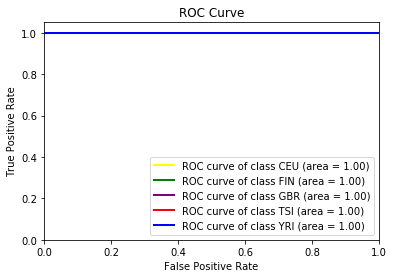

Fold 2


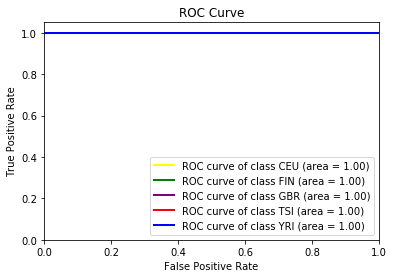

Fold 3


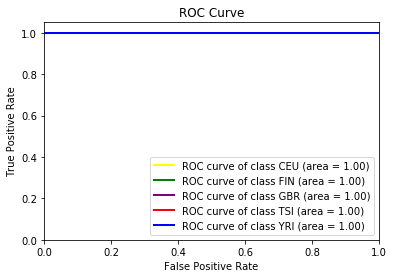

Fold 4


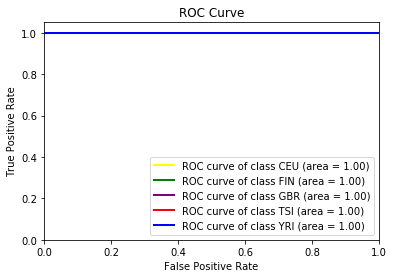

Fold 5


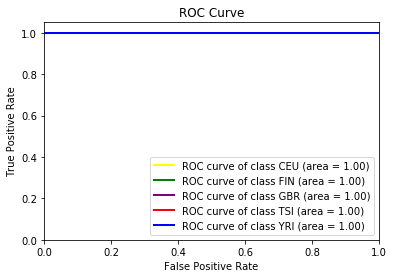

Mean F1-Score:
	 CEU: 100.00%
	FIN: 100.00%
	GBR: 100.00%
	TSI: 100.00%
	YRI: 100.00%
Mean Accuracy: 100.00%


In [122]:
accuracy = []
f1_sc = []
for i in range(1,6):
    print("Fold", i)
    with open('xg_boost_dataset_'+str(i)+'.dat', 'rb') as handle:
        model = pickle.load(handle)
#         print(model)
#         print(X.shape)
        # make predictions for test data
        y_pred = model.predict(select_best_features(dataset, 'dataset_best_features'+str(i)+'.pickle'))
        predictions = [round(value) for value in y_pred]
        # evaluate predictions
        accuracy.append(accuracy_score(sample_vs_label, predictions))
        f1_sc.append(f1_score(sample_vs_label, predictions, average=None))
#         print("F1-Score: ", [ '%.2f' % elem for elem in f1_sc[-1] ])
#         print("Accuracy: %.2f%%" % (accuracy[-1] * 100.0))
        draw_roc_curve(sample_vs_label, y_pred)

print("Mean F1-Score:\n\t", "\n\t".join(['%s: %.2f%%' % (labels[i], elem) for\
                                          (i, elem) in enumerate(np.mean(f1_sc, axis=0)*100)]))
print("Mean Accuracy: %.2f%%" % (np.mean(accuracy) * 100.0))

# XGBOOST WITH EQUIVALENCE CLASS AS FEATURES

Fold 1


/Users/anupam/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


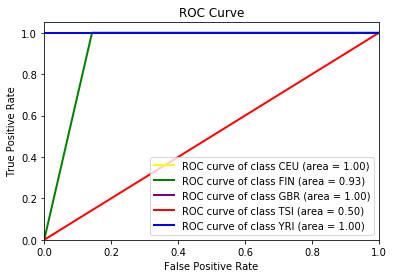

Fold 2


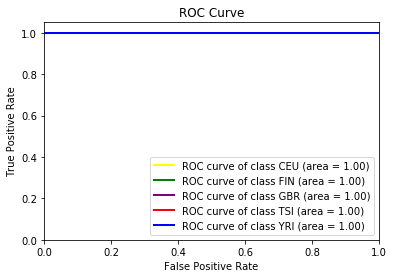

Fold 3


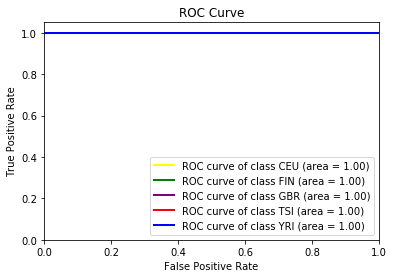

Fold 4


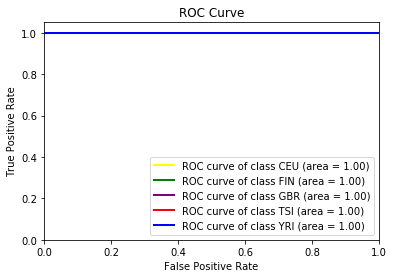

Fold 5


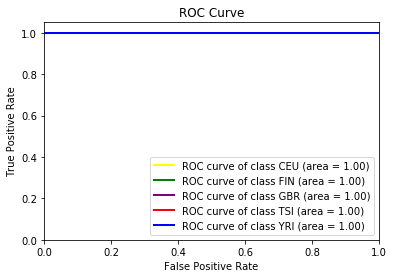

Mean F1-Score:
	 CEU: 100.00%
	FIN: 97.78%
	GBR: 100.00%
	TSI: 80.00%
	YRI: 100.00%
Mean Accuracy: 98.18%


In [123]:
accuracy = []
f1_sc = []

with open('column_mask.pickle', 'rb') as handle:
    mask = pickle.load(handle)
X = np.delete(dataset_eq_class, np.nonzero(mask), axis=1)

for i in range(1,6):
    print("Fold", i)
    with open('xg_boost_equiv_'+str(i)+'.dat', 'rb') as handle:
        model = pickle.load(handle)
#         print(model)
#         print(X.shape)
        # make predictions for test data
        y_pred = model.predict(select_best_features(X, 'equiv_best_features_'+str(i)+'.pickle'))
        predictions = [round(value) for value in y_pred]
        # evaluate predictions
        accuracy.append(accuracy_score(sample_vs_label, predictions))
        f1_sc.append(f1_score(sample_vs_label, predictions, average=None))
#         print("F1-Score: ", [ '%.2f' % elem for elem in f1_sc[-1] ])
#         print("Accuracy: %.2f%%" % (accuracy[-1] * 100.0))
        draw_roc_curve(sample_vs_label, y_pred)

print("Mean F1-Score:\n\t", "\n\t".join(['%s: %.2f%%' % (labels[i], elem) for\
                                          (i, elem) in enumerate(np.mean(f1_sc, axis=0)*100)]))
print("Mean Accuracy: %.2f%%" % (np.mean(accuracy) * 100.0))